In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score


In [3]:
df = pd.read_csv("cybersecurity_intrusion_data.csv")
df.drop(columns=["session_id"], inplace=True)  # Remove ID column

In [4]:
# Label Encoding for categorical columns
categorical_cols = ["protocol_type", "encryption_used", "browser_type"]
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [5]:
# Define target
X = df.drop("attack_detected", axis=1)
y = df["attack_detected"]

In [6]:
selector = SelectKBest(score_func=f_classif, k='all')
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
X = df[selected_features] 

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

In [9]:
# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [10]:

# Predict and evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
acc = accuracy_score(y_test, y_pred)
print(f"🎯 Logistic Regression Accuracy: {acc:.2f}")

🎯 Logistic Regression Accuracy: 0.73


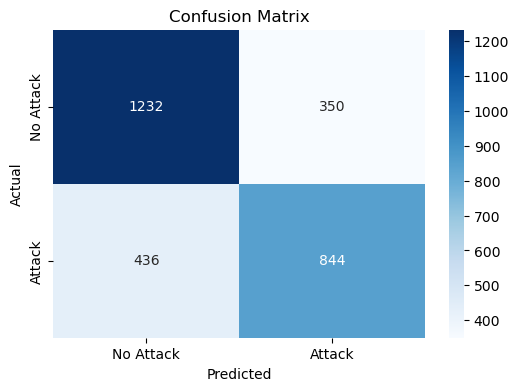

In [11]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Attack", "Attack"], yticklabels=["No Attack", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [12]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.78      0.76      1582
           1       0.71      0.66      0.68      1280

    accuracy                           0.73      2862
   macro avg       0.72      0.72      0.72      2862
weighted avg       0.72      0.73      0.72      2862



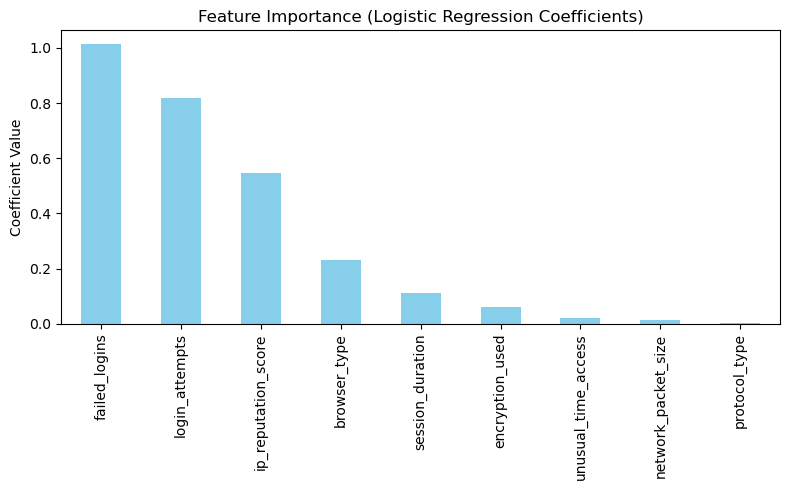

In [13]:
# Feature Importance (for Logistic Regression)
feature_importance = pd.Series(model.coef_[0], index=selected_features).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
feature_importance.plot(kind="bar", color="skyblue")
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.ylabel("Coefficient Value")
plt.tight_layout()
plt.show()

In [14]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)  # Get class predictions
proba_rf = rf.predict_proba(X_test)[:, 1]
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"🌲 Random Forest Accuracy: {acc_rf:.2f}")

🌲 Random Forest Accuracy: 0.89


In [15]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
proba_svm = svm.predict_proba(X_test)[:, 1]  # Probability of class 1 (attack)
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"🎯 SVM Accuracy: {acc_svm:.2f}")

🎯 SVM Accuracy: 0.87


In [16]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, proba_rf)
fpr_svm, tpr_svm, _ = roc_curve(y_test, proba_svm)

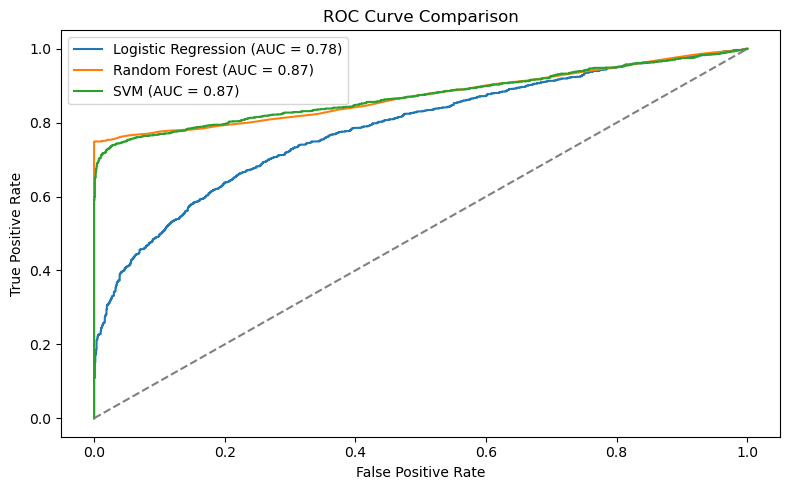

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test, proba_rf):.2f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_score(y_test, proba_svm):.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
new_input = {
    "network_packet_size": 500,
    "protocol_type": 1,           # e.g., 1 for 'https'
    "login_attempts": 6,
    "session_duration": 2.5,
    "encryption_used": 1,         # e.g., 1 if encryption is used
    "ip_reputation_score": 15,    # lower = more risky
    "failed_logins": 5,
    "browser_type": 2,            # e.g., 2 for 'Firefox'
    "unusual_time_access": 1      # e.g., 1 if access time is odd
}

# Convert and scale input
new_df = pd.DataFrame([new_input])
new_df_scaled = scaler.transform(new_df[selected_features])

In [19]:
prediction = model.predict(new_df_scaled)
proba = model.predict_proba(new_df_scaled)

In [20]:
print("🔐 Attack Detected!" if prediction[0] == 1 else "✅ Normal Login")
print(f"⚠️ Probability of being an attack: {proba[0][1]:.2f}")

🔐 Attack Detected!
⚠️ Probability of being an attack: 1.00
